# GitHub Community Health

In [79]:
from scipy.io import arff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Models
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.cluster import AgglomerativeClustering, KMeans

In [2]:
# Apply label encoder to categorical columns
# Return indices of those columns
def categorical_to_numberic(df):
    cols, indices = [], []
    for i, col in enumerate(df):
        if isinstance(df[col][0], bytes):
            cols.append(col)
            indices.append(i)
    atts = [col for col in df if isinstance(df[col][0], bytes)]
    df[cols] = df[cols].apply(LabelEncoder().fit_transform)
    return indices

In [96]:
# Load arff file into pandas dataframe
data = arff.loadarff("github.arff")
df = pd.DataFrame(data[0])

# Delete features
del df["forks_count"]

# Convert categorical data to numeric
cat_cols = categorical_to_numberic(df)

# Impute missing values
df.replace("?", np.NaN, inplace=True)
imputer = SimpleImputer(missing_values=np.nan, strategy="mean")
idf = pd.DataFrame(imputer.fit_transform(df))
idf.columns = df.columns
idf.index = df.index

# Split off collumn we want to predict
predict_attribute = "contributor_count"
X = idf.drop(predict_attribute, axis=1)
y = idf[predict_attribute]

# Normalize inputs, convert to numpy
X = MinMaxScaler().fit_transform(X)
y = y.to_numpy()

# Check out the mean contributor count
print(np.mean(y))

# Randomly sample from the data set
selection = np.random.randint(1, len(X), 200)
X_sample = X[selection]
y_sample = y[selection]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Split sample into train and test sets
X_sample_train, X_sample_test, y_sample_train, y_sample_test = train_test_split(X_sample, y_sample, test_size=0.3)
print(X_sample_train.shape, X_sample_test.shape, y_sample_train.shape, y_sample_test.shape)

27.0077
(9500, 37) (500, 37) (9500,) (500,)
(140, 37) (60, 37) (140,) (60,)


## Feature Analysis

In [15]:
# Plot with n best features
def view_pred(n, n_pred, n_feats):
    pred = n_pred[n]
    print(*[col for col in df.columns[:-1][n_feats[n]]], sep="  ")
    plt.plot(pred, label="Prediction")
    plt.plot(y_sample_test, label="True")
    plt.title(f"{n} best features")
    plt.legend()
    plt.show()

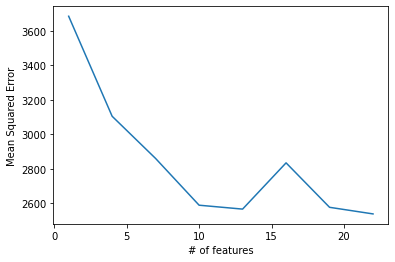

In [13]:
# Sequential feature selection with knn
# Define custom distance metric to handle numeric and categorical data
def my_dist(x, y, cat_cols=[]):
    total = 0
    for i, feature in enumerate(x):
        if i not in cat_cols:
            total += np.abs(feature - y[i])
        elif feature != y[i]:
            total += 0.5
    return total

regr = KNeighborsRegressor(metric=my_dist, metric_params={"cat_cols": cat_cols})
# regr = MLPRegressor(max_iter=10000)
# regr = DecisionTreeRegressor(max_depth=5)
domain = np.arange(1, 25, 3)
n_err = {}
n_pred = {}
n_feats = {}

for i, n in enumerate(domain):
    
    sfs = SequentialFeatureSelector(regr, n_features_to_select=int(n), direction="forward")
    sfs.fit(X_sample_train, y_sample_train)
    feats = sfs.get_support()
    n_feats[n] = feats
    X_reduce = X_sample_test.T[feats].T
    
    regr.fit(X_reduce, y_sample_test)
    pred = regr.predict(X_reduce)
    n_pred[n] = pred
    err = mean_squared_error(y_sample_test, pred)
    n_err[n] = err

# Plot n vs err
plt.plot(domain, n_err.values())
plt.xlabel("# of features")
plt.ylabel("Mean Squared Error")
plt.show()

size  has_issues  has_downloads  open_issues_count  has_support_file  has_security_file  has_codeowners  has_codespaces  has_issue_template  has_pull_request_template  languages_count  primary_language_ratio  milestones_count


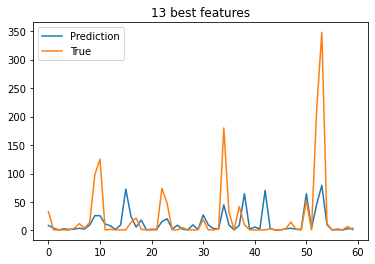

In [20]:
n_best = min(n_err, key=n_err.get)
view_pred(13, n_pred, n_feats)

## Regression

### PCA
Most of the variation in the data can be compressed to ~6 dimentions/features.

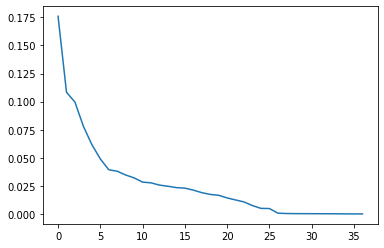

In [72]:
pca = PCA(n_components=37)
pca.fit(X)
plt.plot(pca.explained_variance_ratio_)
plt.plot()

pca = PCA(n_components=6)
X_pca_train = pca.fit_transform(X_train)
X_pca_test = pca.fit_transform(X_test)

### K-Nearest Neighbors

Error: 42.8204


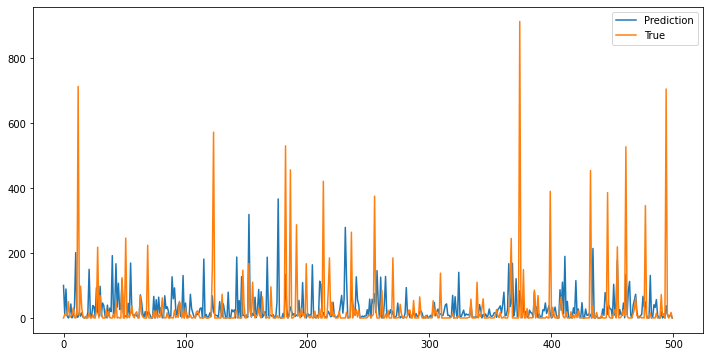

In [73]:
knn = KNeighborsRegressor(metric=my_dist, metric_params={"cat_cols": cat_cols})
knn.fit(X_pca_train, y_train)
pred = knn.predict(X_pca_test)
err = mean_absolute_error(y_test, pred)
print(f"Error: {err}")
plt.figure(figsize=(12,6))
plt.plot(pred, label="Prediction")
plt.plot(y_test, label="True")
plt.legend()
plt.show()

### Multilayer Perceptron

### Decision Tree
The decision tree starts to overfit after 7 layers. It does much better then Knn.

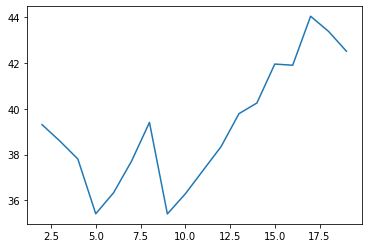

Error: 35.41235540062592


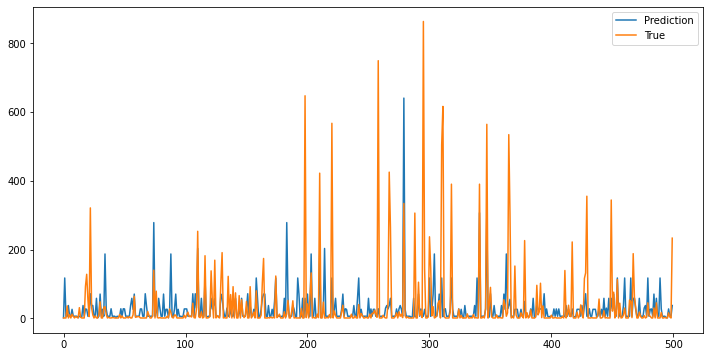

In [98]:
dom = np.arange(2, 20)
errs = []
for i in dom:
    decisionTree = DecisionTreeRegressor(max_depth=i)
    decisionTree.fit(X_train, y_train)
    pred = decisionTree.predict(X_test)
    err = mean_absolute_error(y_test, pred)
    errs.append(err)
plt.plot(dom, errs)
plt.show()

decisionTree = DecisionTreeRegressor(max_depth=5)
decisionTree.fit(X_train, y_train)
pred = decisionTree.predict(X_test)
err = mean_absolute_error(y_test, pred)
print(f"Error: {err}")
plt.figure(figsize=(12,6))
plt.plot(pred, label="Prediction")
plt.plot(y_test, label="True")
plt.legend()
plt.show()

## Clustering

### Kmeans
The Silhouette score is quite good, especially for k=2. The cluster sizes are also somewhat reasonable. My guess is that it basically partitioned the ~2.5% of the repos with > 100 contributors.

2 cluster sizes: [9746  254]
3 cluster sizes: [9354  131  515]
4 cluster sizes: [8990  106  207  697]
5 cluster sizes: [8787  121  265   57  770]
6 cluster sizes: [8664  104  300   43  824   65]
7 cluster sizes: [8170   43  213   91  437   65  981]


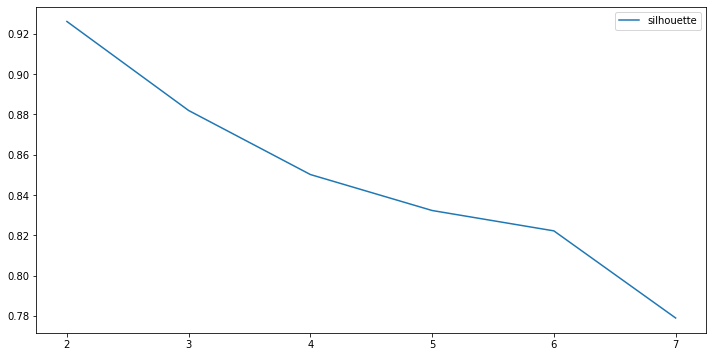

In [92]:
sil = []
data = np.column_stack((X, y))
dom = np.arange(2, 8)
for k in dom:
    kmeans = KMeans(n_clusters=k)
    clusters = kmeans.fit_predict(data)
    print(f"{k} cluster sizes: {np.unique(clusters, return_counts=True)[1]}")
    sil.append(silhouette_score(data, clusters))

plt.figure(figsize=(12, 6))
plt.plot(dom, sil, label="silhouette")
plt.legend()
plt.show()

### HAC